# Instalação de Dependências

In [1]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Modelagem

Foi montado um grafo com os times duplicados com tags de mandantes ou não-mandantes. As arestas são modificadas de acordo com as rodadas indicando se pode existir um jogo entre dois vértices. As restrições de mandantes são feitas através de uma modificação no algoritmo de coloração. Além disso, o algoritmo de coloração passa a colorir no máximo dois vértices com a mesma cor, já que uma partida não pode ter mais de dois times.

Mais informações serão aprensentadas na parte dos resultados.

# Códigos Base

In [45]:
from typing import Tuple
from dataclasses import dataclass


# Significa que os times dentro desta tupla não
# podem ser mandantes na mesma rodada
@dataclass
class HostRestrict:
    hosts: Tuple[str, str]


# Esse jogo não pode acontencer nesta rodada.
# Atenção: O mandante importa.
@dataclass
class GameRestrict:
    host: str
    other: str


@dataclass
class Team:
    id: int
    name: str

In [46]:
import networkx as nx
import matplotlib.pyplot as plt

from typing import Mapping, List, Tuple


class Graph:
    def __init__(self, nodes: List[Team]):
        self._graph = nx.Graph()
        self._pos: Mapping = None

        for node in nodes:
            self._graph.add_node(node.name)

        # Número de vértices
        self.nodes = nodes
        self.edges: List[Tuple[Team, Team]] = []

        # Lista de adjacência
        self._neighbours = [[] for _ in nodes]

        self._draw_params = {
            "with_labels": True,
            "node_color": "skyblue",
            "node_size": 100,
            "edge_color": "gray",
            "font_weight": "bold",
            "font_size": 8,
        }

    def neighbours(self, v: Team) -> List[Team]:
        # Função auxiliadora para encontrar vizinhos de um vértice.
        # Subtraímos 1 pois a nossa lista começa em 0.
        return self._neighbours[v.id]

    def insert_edge(self, v1: Team, v2: Team):
        self._graph.add_edge(v1.name, v2.name)
        self.edges.append((v1, v2))

        self.neighbours(v1).append(v2)
        self.neighbours(v2).append(v1)

    def has_edge(self, v1: Team, v2: Team):
        v2 in self.neighbours(v1)

    def node_degree(self, v: Team) -> int:
        return len(self.neighbours(v))

    def _reload_pos(self):
        self._pos = nx.spring_layout(self._graph)

    def _load_pos(self):
        if self._pos is None:
            self._reload_pos()

    def _create_view(self, node_colors=None):
        self._load_pos()

        plt.figure(3, figsize=(12, 12))
        draw_params = self._draw_params.copy()
        if node_colors:
            draw_params["node_color"] = node_colors

        nx.draw_networkx(self._graph, pos=self._pos, alpha=0.9, **draw_params)

    def view(self):
        self._create_view()
        plt.title("Jogos")
        plt.show()

    def view_colored(self, color_map: List[List[Team]]):
        """Displays the graph with nodes colored according to the coloring algorithm."""
        colors = [
            "red",
            "blue",
            "green",
            "yellow",
            "orange",
            "purple",
            "cyan",
            "magenta",
            "brown",
            "pink",
            "lime",
            "teal",
            "gold",
            "violet",
        ]
        node_colors = ["gray" for _ in self.nodes]
        for i, nodes in enumerate(color_map):
            for node in nodes:
                node_colors[node.id] = colors[i]

        self._create_view(node_colors)
        plt.title("Jogos - Colored Graph")
        plt.show()

In [47]:
from typing import Dict, Set
import random


class Game:
    def __init__(self, teams: List[str], matches: int):
        self.teams = teams
        self.matches = matches

        self.matches_played: List[List[List[Team]]] = []

        self.host_restrictions: List[HostRestrict] = []
        self.game_restrictions: List[List[GameRestrict]] = [
            [] for _ in range(self.matches)
        ]

        self._teams_map: Dict[str, int] = {}
        self._load_teams_map()

    def _load_teams_map(self):
        for i, team in enumerate(self.teams):
            self._teams_map[team] = i

    def lookup_team(self, team: str) -> int:
        return self._teams_map[team]

    def ruler_teams(self) -> List[str]:
        ruler_teams: List[str] = []
        for team in self.teams:
            ruler_teams.append(f"M{team}")
        for team in self.teams:
            ruler_teams.append(f"N{team}")

        return ruler_teams

    def ruler_teams_full(self) -> List[str]:
        ruler_teams: List[str] = []
        for i, team in enumerate(self.teams):
            ruler_teams.append(Team(i, f"M{team}"))
        for i, team in enumerate(self.teams):
            ruler_teams.append(Team(i + len(self.teams), f"N{team}"))

        return ruler_teams

    def lookup_ruler_team(self, team: str, ruler: bool) -> Team:
        team_id = self.lookup_team(team)
        return (
            Team(team_id, f"M{team}")
            if ruler
            else Team(team_id + len(self.teams), f"N{team}")
        )

    def insert_host_restriction(self, hosts: Tuple[str, str]):
        self.host_restrictions.append(HostRestrict(hosts))

    def insert_game_restriction(self, matches: List[int], host: str, other: str):
        for match in matches:
            restrict = GameRestrict(host, other)
            if match > self.matches:
                restrict = GameRestrict(other, host)
                if match > self.matches * 2:
                    raise ValueError(f"O jogo tem apenas {self.matches} rodadas.")

                match = match - self.matches

            self.game_restrictions[match - 1].append(restrict)

    def build_graph(self):
        # Criar grafo com times duplicados
        # Teams terão inicial M para mandantes e N para não-mandantes.
        graph = Graph(self.ruler_teams_full())

        # Obviamente existirá uma restrição para mesmos times
        for team in self.teams:
            ruler, not_ruler = [self.lookup_ruler_team(team, b) for b in [True, False]]
            graph.insert_edge(ruler, not_ruler)

        # Além disso mandantes não podem fazer jogos com outros mandantes
        # E não-mandantes não podem fazer jogos com outros.
        for team1 in self.teams:
            mteam1 = self.lookup_ruler_team(team1, True)
            nteam1 = self.lookup_ruler_team(team1, False)

            for team2 in self.teams:
                mteam2 = self.lookup_ruler_team(team2, True)
                nteam2 = self.lookup_ruler_team(team2, False)

                graph.insert_edge(mteam1, mteam2)
                graph.insert_edge(nteam1, nteam2)

        for teams_match in self.matches_played:
            if len(teams_match) == 2:
                team1, team2 = teams_match

                graph.insert_edge(
                    self.lookup_ruler_team(team1, True),
                    self.lookup_ruler_team(team2, False),
                )

                graph.insert_edge(
                    self.lookup_ruler_team(team2, True),
                    self.lookup_ruler_team(team1, False),
                )

        match = len(self.matches_played)
        for restriction in self.game_restrictions[match - 1]:
            host = self.lookup_ruler_team(restriction.host, True)
            other = self.lookup_ruler_team(restriction.other, False)

            graph.insert_edge(host, other)

        for restriction in self.host_restrictions:
            first, second = restriction.hosts
            host_1 = self.lookup_ruler_team(first, True)
            host_2 = self.lookup_ruler_team(second, True)

            graph.insert_edge(host_1, host_2)

        return graph

    def min_color(self, colors: List[List[Team]], exclude: Set[int]) -> int:
        min_id, min_color = None, None
        for i, color in enumerate(colors):
            if i in exclude or len(color) >= 2:
                continue

            if min_color is None or len(color) < min_color:
                min_id = i
                min_color = len(color)

        return min_id
    
    def select_order(self) -> List[str]:
        # Talvez eu possa substituir isso por criar uma ligação com ele mesmo

        teams_copy = set(self.teams)
        team_order: List[str] = []
        for match in self.matches_played[::-1]:
            for teams in match:
                if len(teams) == 1:
                    team = teams[0].name[1:]
                    teams_copy.discard(team)
                    team_order.append(team)
                    break
        
        return team_order + random.sample(list(teams_copy), len(teams_copy))

    def color_graph(self, graph: Graph) -> List[List[Team]]:
        colors: List[List[Team]] = []
        color_map: List[Team] = [None for _ in graph.nodes]

        isolated_colors: Set[int] = set()
        chosen_teams: Set[str] = set()
        force_isolation: Set[str] = set()

        ruler = True
        for team in self.select_order():
            if team in chosen_teams:
                continue

            v = self.lookup_ruler_team(team, ruler)

            exclude = isolated_colors.copy()
            for neighbour in graph.neighbours(v):
                if color_map[neighbour.id] is not None:
                    exclude.add(color_map[neighbour.id])

            color = self.min_color(colors, exclude)
            if color is None:
                if team in force_isolation:
                    isolated_colors.add(len(colors))

                color_map[v.id] = len(colors)
                colors.append([v])

                for restriction in self.host_restrictions:
                    if team == restriction.hosts[0]:
                        force_isolation.add(restriction.hosts[1])
                    elif team == restriction.hosts[1]:
                        force_isolation.add(restriction.hosts[0])
            else:
                color_map[v.id] = color
                colors[color].append(v)

            ruler = not ruler
            chosen_teams.add(team)

        return colors
    
    def print_colors(self, match: int, colors: List[List[Team]], excluded=True):
        matches = []
        excluded = []
        for teams in colors:
            if len(teams) == 1:
                excluded.append(teams[0].name[1:])
            else:
                matches.append("x".join([team.name[1:] for team in teams]))

        print(f"Partida #{match}: {' | '.join(matches)}")
        if excluded:
            print(f"Times que não foram escolhidos: {', '.join(excluded)}")

    def restart_game(self):
        self.matches_played = []

    def play_match(self) -> Tuple[Graph, List[List[Team]]]:
        graph = self.build_graph()
        colors = self.color_graph(graph)
        self.matches_played.append(colors)
        
        return graph, colors
    
    def show_tournament(self, games: List[List[List[Team]]]):
        for i, round in enumerate(games):
            self.print_colors(i+1, round, False)
    
    def play_tournament(self):
        self.restart_game()
        games: List[List[List[Team]]] = []
        for i in range(self.matches):
            success = False
            
            games.append([])
            for _ in range(5):
                _, colors = self.play_match()

                ones = 0
                for color in colors:
                    if len(color) == 1:
                        ones += 1

                if ones <= 1:
                    for color in colors:
                        if len(color) == 2:
                            games[i].append(color)
                    
                    success = True
                    break
            
            if not success:
                raise ValueError("Torunament Failed.")
            
        for i in range(self.matches):
            games.append([[second, first] for first, second in games[i]])
    
        return games

# Criação da Partida
Abaixo inserimos os times e restrições de acordo com a especificação enviada pelo professor.

In [48]:
times, matches = ["DFC", "TFC", "AFC", "LFC", "FFC", "OFC", "CFC"], 7
game = Game(times, matches)

game.insert_game_restriction([1, 14], "DFC", "CFC")

game.insert_host_restriction(("TFC", "OFC"))
game.insert_host_restriction(("AFC", "FFC"))

game.insert_game_restriction([7, 13], "LFC", "FFC")
game.insert_game_restriction([10, 11], "OFC", "LFC")
game.insert_game_restriction([12, 13], "AFC", "FFC")
game.insert_game_restriction([2, 3], "CFC", "TFC")

# O Grafo

Abaixo apresentamos o grafo. As arestas indicam as restrições, ou seja, os vértices que não podem formar partida juntos.

O M antes significa mandante e o N, não mandante. Obviamente mandantes não podem formar partidas entre si, nem não-mandantes entre si, já que não faria sentido uma partida com dois mandantes ou nenhum mandante.

Além disso, times não podem formar partidas com os mesmos. Exemplo MAFC possui uma aresta com NAFC, pois não pode existir uma partida de um time com ele mesmo.

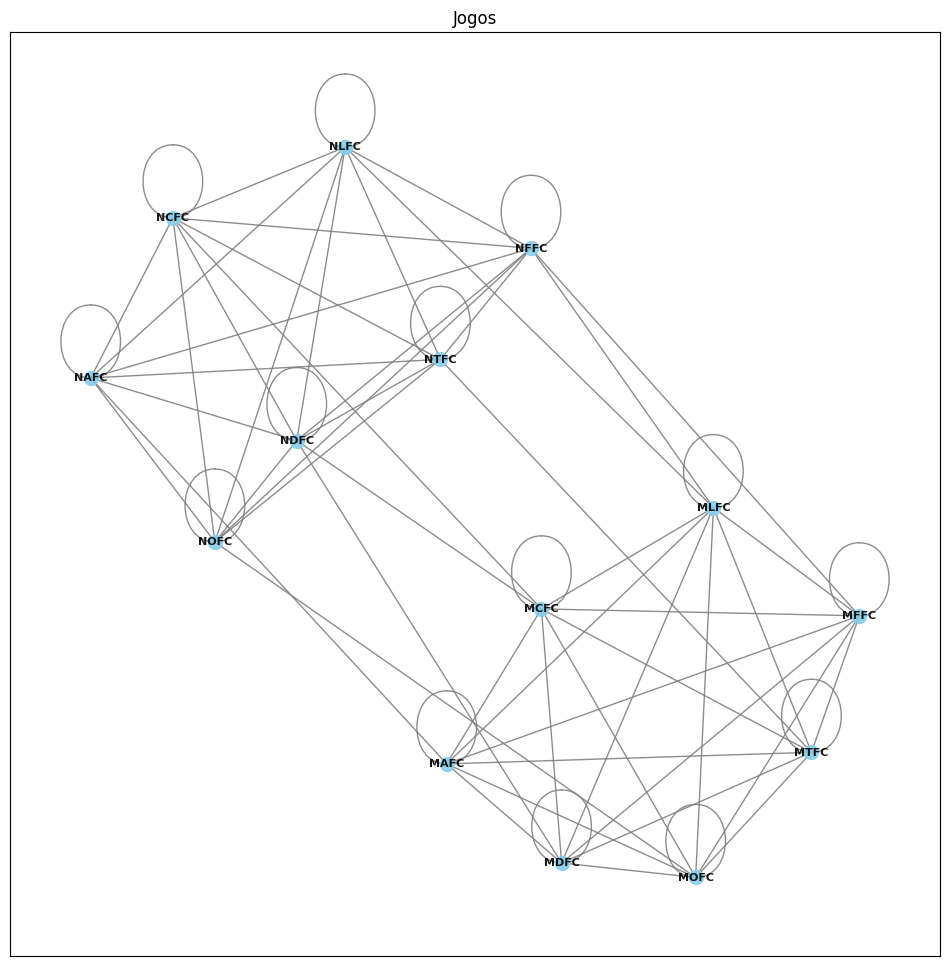

In [49]:
graph = game.build_graph()
graph.view()

# Coloração

Abaixo apresentamos a coloração da primeira rodada. Os vértices em cinza significa aqueles que não foram escolhidos. Enquanto que as cores indicam as partidas da rodada.

Partida #1: FFCxAFC | LFCxDFC | OFCxCFC
Times que não foram escolhidos: TFC


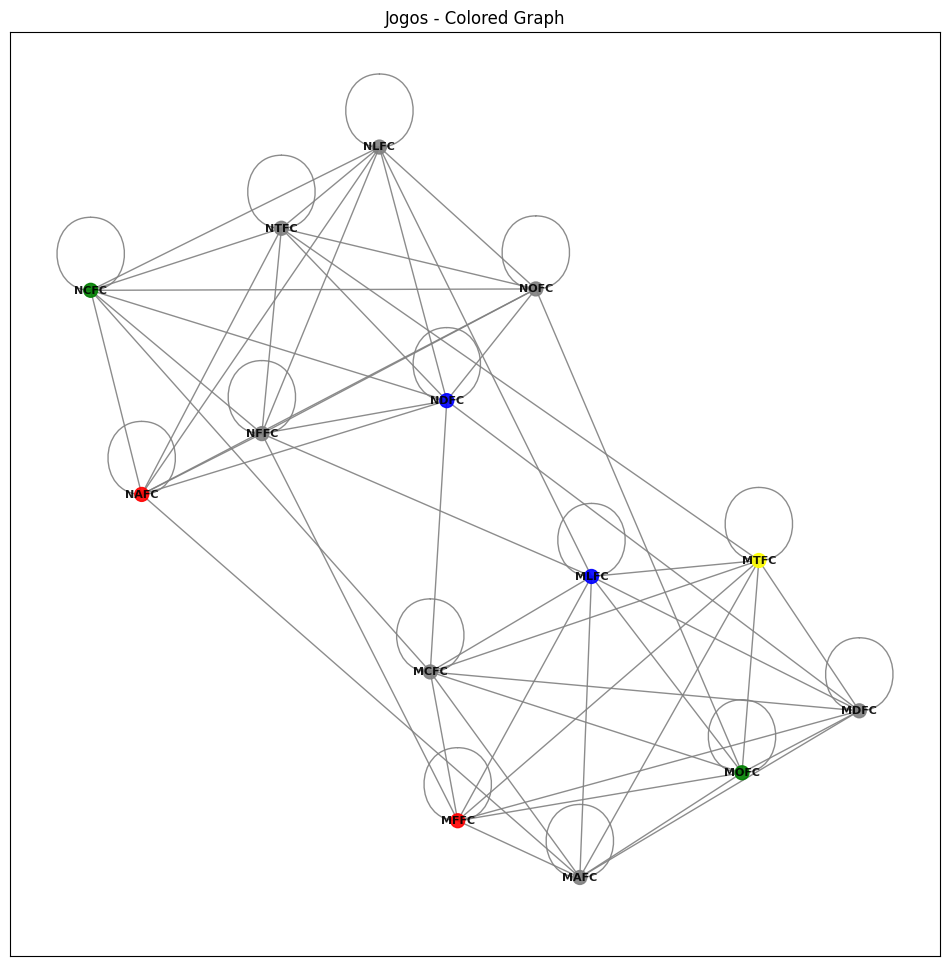

In [50]:
game.restart_game()
graph, colors = game.play_match()
game.print_colors(len(game.matches_played), colors)
graph.view_colored(colors)

Agora, um exemplo da segunda rodada.

Partida #2: TFCxDFC | AFCxCFC | LFCxOFC
Times que não foram escolhidos: FFC


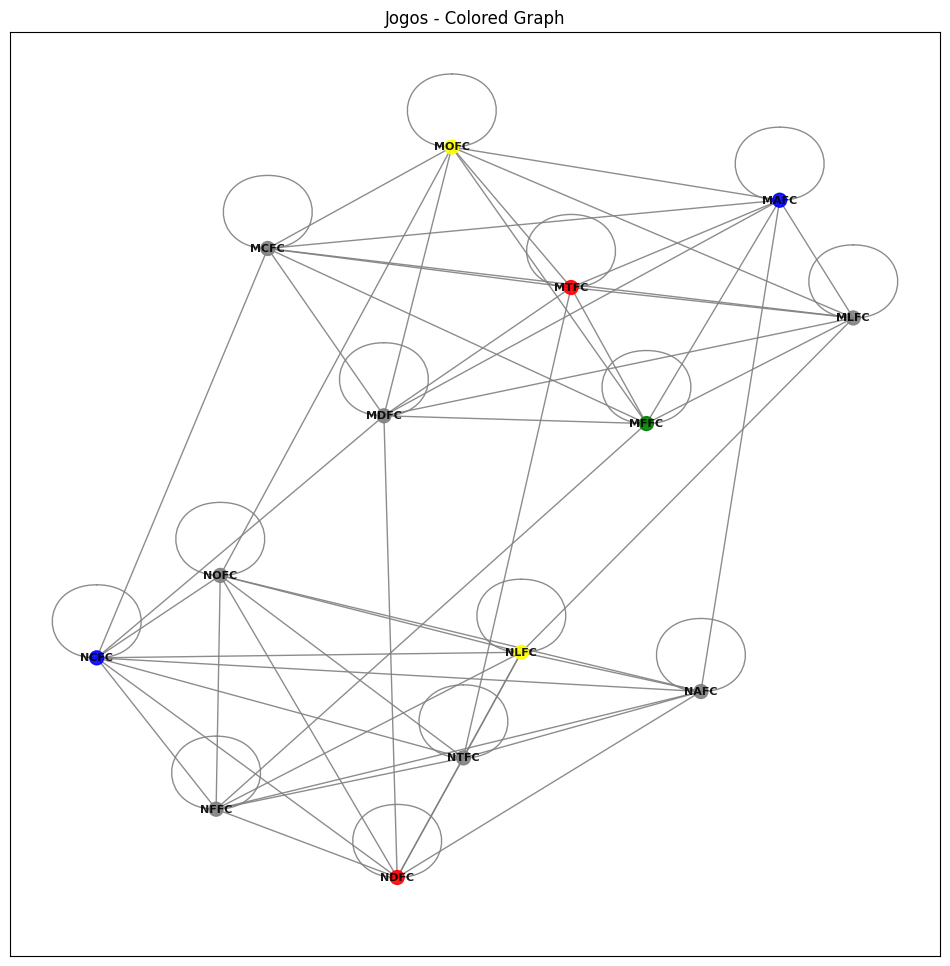

In [51]:
graph, colors = game.play_match()
game.print_colors(len(game.matches_played), colors)
graph.view_colored(colors)

Agora, mostramos a execução do jogo completo e o resultado final.

In [52]:
games = game.play_tournament()
game.show_tournament(games)

Partida #1: AFCxOFC | LFCxDFC | CFCxTFC
Partida #2: FFCxDFC | CFCxTFC | LFCxAFC
Partida #3: OFCxFFC | LFCxCFC | DFCxAFC
Partida #4: TFCxOFC | FFCxCFC | LFCxDFC
Partida #5: AFCxTFC | OFCxFFC | CFCxLFC
Partida #6: DFCxAFC | TFCxOFC | FFCxLFC
Partida #7: CFCxDFC | AFCxTFC | OFCxFFC
Partida #8: OFCxAFC | DFCxLFC | TFCxCFC
Partida #9: DFCxFFC | TFCxCFC | AFCxLFC
Partida #10: FFCxOFC | CFCxLFC | AFCxDFC
Partida #11: OFCxTFC | CFCxFFC | DFCxLFC
Partida #12: TFCxAFC | FFCxOFC | LFCxCFC
Partida #13: AFCxDFC | OFCxTFC | LFCxFFC
Partida #14: DFCxCFC | TFCxAFC | FFCxOFC
